In [1]:
import sys
import gym
import numpy as np
from collections import defaultdict

In [2]:
env = gym.make('Blackjack-v0')

In [3]:
print(env.observation_space)
print(env.action_space)

Tuple(Discrete(32), Discrete(11), Discrete(2))
Discrete(2)


In [4]:
for episode in range(3):
    state = env.reset()
    while True:
        print(state)
        action = env.action_space.sample()
        print("Action Taken by user:", "Hit" if action == 1 else "Stick")
        state, reward, done, info = env.step(action)
        print("reward Recieved:", reward)
        if done:
            print("End Game! Reward: ", reward)
            print('You won :)\n') if reward > 0 else print('You lost :(\n')
            break

(20, 10, False)
Action Taken by user: Stick
reward Recieved: 1.0
End Game! Reward:  1.0
You won :)

(19, 10, False)
Action Taken by user: Stick
reward Recieved: 1.0
End Game! Reward:  1.0
You won :)

(17, 6, True)
Action Taken by user: Hit
reward Recieved: 0.0
(12, 6, False)
Action Taken by user: Hit
reward Recieved: -1.0
End Game! Reward:  -1.0
You lost :(



Implementing a function returning episodes with limiting stochiastic policy given as :
" Player Takes action "Stick" with 80% prob if sum of his cards ( first element in the state tuple) is greater than 18 , if the sum is less than 18 player takes action "Hit" "

In [5]:
def generate_episodes_based_on_policy(env):
    episode = []
    state = env.reset()
    while True:
        probs = [0.8,0.2] if state[0] > 18 else [0.2, 0.8]
        action = np.random.choice(np.arange(2), p=probs)
        next_state, reward, done, info = env.step(action)
        episode.append((state, action, reward))
        state = next_state
        if done:
            break
    return episode

In [6]:
for i in range(3):
    print(generate_episodes_based_on_policy(env))

[((8, 6, False), 1, 0.0), ((11, 6, False), 1, 0.0), ((20, 6, False), 0, 1.0)]
[((20, 4, False), 0, 1.0)]
[((18, 1, False), 1, -1.0)]


In [23]:
def mc_q_prediction(env, num_episodes, generate_episode, gamma=1.0):
    returns_sum = defaultdict(lambda: np.zeros(env.action_space.n))
    N = defaultdict(lambda: np.zeros(env.action_space.n))
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    for episode in range(1, num_episodes):
        if (episode % 1000) == 0:
            print("\rEpisode {}/{}.".format(episode, num_episodes), end="")
            sys.stdout.flush()
        episode = generate_episode(env)
        states, actions, rewards = zip(*episode)
        discounts = np.array([gamma**i for i in range(len(rewards)+1)])
        for i, state in enumerate(states):
            returns_sum[state][actions[i]] += sum(rewards[i:]*discounts[:-(1+i)])
            N[state][actions[i]] += 1
            Q[state][actions[i]] = returns_sum[state][actions[i]] / N[state][actions[i]]
    return Q

Episode 499000/500000.

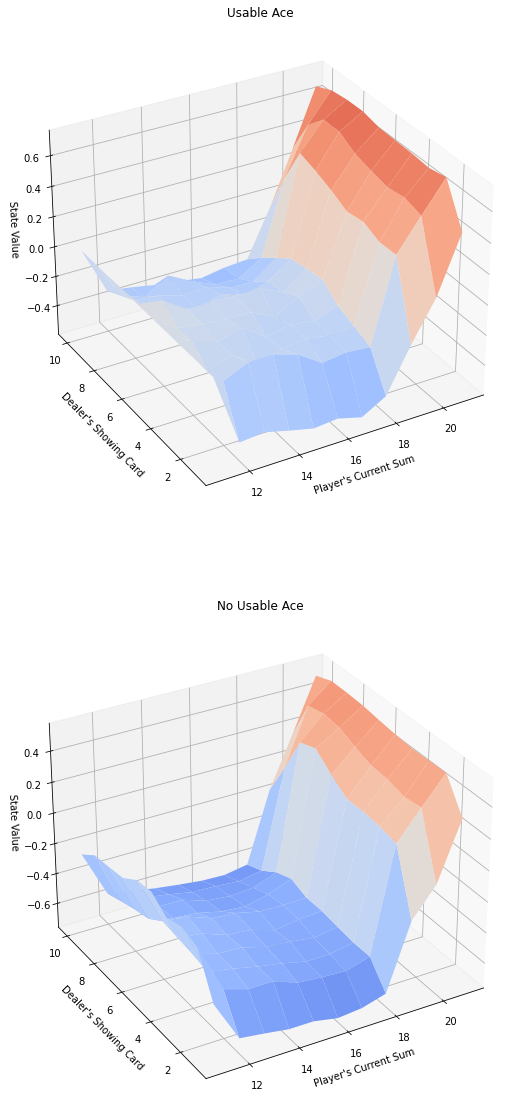

In [24]:
from plot_utils import plot_blackjack_values, plot_policy


# obtain the action-value function
Q = mc_q_prediction(env, 500000, generate_episodes_based_on_policy)

# obtain the corresponding state-value function
V_to_plot = dict((k,(k[0]>18)*(np.dot([0.8, 0.2],v)) + (k[0]<=18)*(np.dot([0.2, 0.8],v))) \
         for k, v in Q.items())

# plot the state-value function
plot_blackjack_values(V_to_plot)

In [26]:
def generate_ep_from_QTable(env, Q, epsilon, nA):
    episode = []
    state = env.reset()
    while True:
        action = np.random.choice(np.arange(nA), p=get_probs(Q[state], epsilon, nA)) if state in Q else env.action_space.sample()
        next_state, reward, done, info = env.step(action)
        episode.append((state, action, reward))
        state = next_state
        if done:
            break;
    return episode

def get_probs(Q, epsilon, nA):
    policy_s = np.ones(nA) * epsilon/nA
    best_a = np.argmax(Q)
    policy_s[best_a] = 1-epsilon + epsilon/nA
    return policy_s

def update_Q(env, episode, Q, alpha, gamma):
    states, actions, rewards = zip(*episode)
    discounts = np.array([gamma**i for i in range(len(rewards)+1)])
    for i, state in enumerate(states):
        old_Q = Q[state][actions[i]]
        Q[state][actions[i]] = old_Q + alpha*(sum(rewards[i:]*discounts[:-(1+i)]) - old_Q)
    return Q

In [28]:
def mc_control(env, num_episodes, alpha, gamma=1.0, eps_start=1.0, eps_decay=.99999, eps_min=0.05):
    nA = env.action_space.n
    Q = defaultdict(lambda: np.zeros(nA))
    epsilon = eps_start
    for i_episode in range(1, num_episodes+1):
        if i_episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush()
        epsilon = max(epsilon*eps_decay, eps_min)
        episode = generate_ep_from_QTable(env, Q, epsilon, nA)
        Q = update_Q(env, episode, Q, alpha, gamma)
    policy = dict((k,np.argmax(v)) for k, v in Q.items())
    return policy, Q

policy, Q = mc_control(env, 500000, 0.02)

Episode 500000/500000.

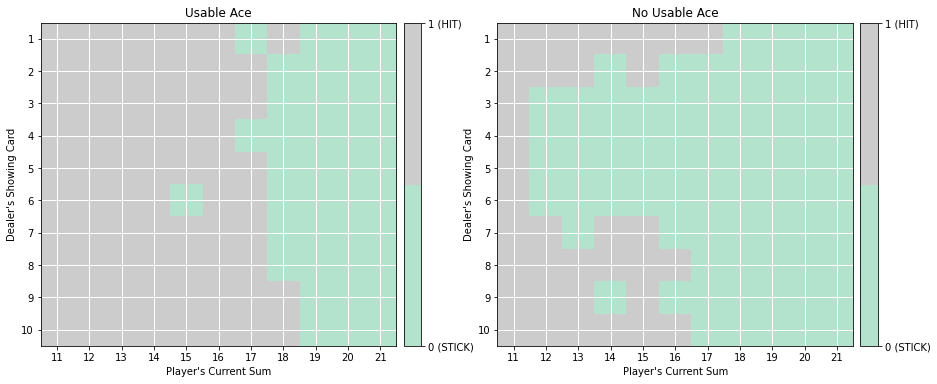

In [29]:
plot_policy(policy)